## Programming Assignment 5
#### In this assignment, you will be implementing Tomasi-Kanade	Factorization algorithm	for Rigid Structure from Motion.

### Task 1
#### Load the data file and generate a 2D image dataset	by generating an orthographic camera with optical axis parallel to the XY plane, which rotates around the teapot	in 10° increments and always looks towards the center of the object
#### Note: Code for loading the point cloud and visualizing it has been given to you. Further build on it and take images of the teapot and visualize them

In [47]:
from scipy.io import loadmat
import numpy as np
x = loadmat('teapot.mat')

In [48]:
a = []
b = []
c = []
for points in x['verts']:
    a.append(points[0])
    b.append(points[1])
    c.append(points[2])

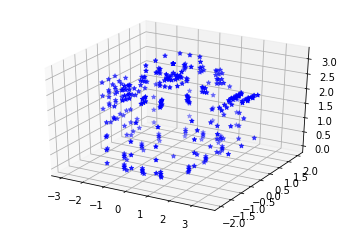

In [49]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(a,b,c, c='b', marker='*')
plt.show()

In [50]:
print(len(b))

306


In [51]:
### Your implementation comes here
intrinsic = np.array([[1, 0, 0],[0, 1, 0]])

def rotation_matrix_y(angle):
    rot_angle=math.radians(angle)
    R = np.array([[math.cos(rot_angle),0,math.sin(rot_angle)],[0,1,0],[-math.sin(rot_angle),0,math.cos(rot_angle)]])
    return R      

In [52]:
### Your implementation comes here
# Hint: new2Dpts = K[R|T]*3DPoints
import math

new2Dpts = []
for i in range(0, len(b)):
    new3Dpoint = np.array([[a[i]],[b[i]], [c[i]]])
    listA = []
    for angle in range (0, 360, 10):
        listA.append(intrinsic @ rotation_matrix_y(angle) @ new3Dpoint)
    new2Dpts.append(listA)

### Task 2
#### Use the data generated in previous task to generate a W matrix, and use that as input in Tomasi Kanade Factorization method to compute the 3D structure

In [53]:
### Your implementation for Tomasi Kanade Factorization method comes here
W = []
for x in range(0,36):
    temp = []
    for i in range(0,306):
        z = new2Dpts[i][x][0][0]
        temp.append(z)
    W.append(temp)
    temp = []
    for i in range(0,306):  
        z = new2Dpts[i][x][1][0]
        temp.append(z)
    W.append(temp)

# We got the W matrix
W = np.array(W)
print(W.shape)

(72, 306)


In [54]:
# U,E,V = np.linalg.svd(W)
u, s, vh = np.linalg.svd(W, full_matrices=True)

u = u[:, 0:3]
s = s[0:3]
vh = vh[0:3, :]

R_hat = u * s
S_hat = vh

k = np.linalg.norm(R_hat, axis=1).mean()

R_hat = R_hat / k
S_hat = S_hat * k

print(R_hat.shape)
print(S_hat.shape)

(72, 3)
(3, 306)


In [55]:
A = []
b_vector = []
for i in range(0,72,2):
    # Select 2 rows
    h = R_hat[i:i+2,:]
    # Form 3 equations
    r1 = h[0][0]
    r2 = h[0][1]
    r3 = h[0][2]
    r4 = h[1][0]
    r5 = h[1][1]
    r6 = h[1][2]
    # Append them to your A matrix
    equation1 = [r1*r1, 2*r1*r2, 2*r1*r3, r2*r2, 2*r2*r3, r3*r3]
    A.append(equation1)
    equation2 = [r4*r1, r4*r2 + r5*r1, r4*r3+r6*r1, r5*r2, r5*r3+r6*r2, r6*r3]
    A.append(equation2)
    equation3 = [r4*r4, 2*r4*r5, 2*r4*r6, r5*r5, 2*r6*r5, r6*r6]
    A.append(equation3)
    # Append three rows in b vector
    b_vector.append([1])
    b_vector.append([0])
    b_vector.append([1])

resultAfterPsuedoInverse = np.linalg.pinv(A) @ b_vector
q1 = resultAfterPsuedoInverse[0][0]
q2 = resultAfterPsuedoInverse[1][0]
q3 = resultAfterPsuedoInverse[2][0]
q4 = resultAfterPsuedoInverse[3][0]
q5 = resultAfterPsuedoInverse[4][0]
q6 = resultAfterPsuedoInverse[5][0]

newQmatrix = []
newQmatrix.append([q1,q2,q3])
newQmatrix.append([q2,q4,q5])
newQmatrix.append([q3,q5,q6])

Q = np.linalg.cholesky(newQmatrix)

S = np.linalg.inv(Q) @ S_hat

In [56]:
## Evaluate your reconstruction
# In the base code above we copied the x, y and z component of the 3D points
# in teapot 3D model that we loaded from teapot.mat in variables a, b, and c respectively
# Assuming the x, y and z component of the 3D points that you have reconstructed are 
# in variables a1, b1 and c1 respectively, the error in reconstruction can be calcualted as:
a1 = S[0]
b1 = S[1]
c1 = S[2]


err = 0.0
j = 0
for i in range(len(a1)):
    err = err + math.sqrt( ((a1[i]-a[i])*(a1[i]-a[i])) + ((b1[i]-b[i])*(b1[i]-b[i])) + ((c1[i]-c[i])*(c1[i]-c[i])) )
    j=j+1

print ("Mean Euclidean Error : ",(err/j))

Mean Euclidean Error :  3.8790907355306166


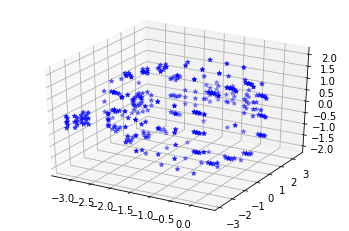

In [57]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(a1,b1,c1, c='b', marker='*')
plt.show()